In [1]:
#python specific stuff
import numpy as np
import matplotlib.pyplot as plt
import time
from functions import *


In [2]:
## INITIALIZATION for time
total_time_h=3 #hours
t_step=10 #s
total_time_s=total_time_h*60*60
N_t_steps=int(total_time_s/t_step)

In [3]:
# # UPPER ROOM INITIALIZATION #########################

#SI units only =m, s, kg, C
 
#this room is where the heat is added and is the starting point of calculation (for the moment we are assuming it is the upper part
#for the surfaces, the outside edge is fixed at it's initial_T
#OUTPUT SURFACE INITIALIZATION
#use function output_surface_parameters() to define parameters

#output_surface_parameters;
#(THcond,HTC,densityC,thickness,area,N_cells,initial_T) ->see functions.py for more details
N_cells=10
initial_T=10

ceiling=output_surface_parameters(0.1,6.4,494000,0.05,500,N_cells,initial_T)
wall_upper=output_surface_parameters(1.3,6.4,1680000,0.175,250,N_cells,initial_T)
windows_upper=output_surface_parameters(1.3,6.4,1680000,0.175,250,N_cells,initial_T)

output_surface_array_upper=[ceiling,wall_upper,windows_upper]

#ROOM PARAMETERS
T_room_upper=initial_T 
Qin_upper_max=71874;
volume_room_upper=1630.43
densityC_room_upper =1206
U_upper=70 # this is for conductive heat to the lower level??
airchanges_per_hour_upper=.5


# MIDDLE ROOM INITIALIZATION #########################

#OUTPUT SURFACE INITIALIZATION

wall_middle=output_surface_parameters(1.3,6.4,1680000,0.175,210,N_cells,initial_T)
windows_middle=output_surface_parameters(1.3,6.4,1680000,0.175,250,N_cells,initial_T)
output_surface_array_middle=[wall_middle,windows_middle]

#ROOM PARAMETERS
T_room_middle=initial_T
volume_room_middle=1369.565
densityC_room_middle =1206
Qin_middle_max=0;
U_middle=70
airchanges_per_hour_middle=0.1

# LOWER ROOM INITIALIZATION #########################

#OUTPUT SURFACE INITIALIZATION
floor=output_surface_parameters(1,6.4,1680000,0.175,500,N_cells,initial_T)
wall_lower=output_surface_parameters(1.3,6.4,1680000,0.175,210,N_cells,initial_T)
output_surface_array_lower=[wall_lower,floor]

#ROOM PARAMETERS
T_room_lower=initial_T
volume_room_lower=1369.565
densityC_room_lower =1206
Qin_lower_max=0
airchanges_per_hour_lower=0.1

T_ext=initial_T
T_target=13.5

In [4]:
## DO CALCULATION ##################

data_array_T_room_upper=np.zeros(int(N_t_steps))
data_array_T_room_middle=np.zeros(int(N_t_steps))
data_array_T_room_lower=np.zeros(int(N_t_steps))
data_array_T_wall_lower=np.zeros(int(N_t_steps))
data_array_T_wall_upper=np.zeros(int(N_t_steps))
data_array_T_ceiling=np.zeros(int(N_t_steps))
data_array_T_floor=np.zeros(int(N_t_steps))

Qin_cumul=[0]

for t in range(N_t_steps):

    data_array_T_room_upper[t]=T_room_upper
    data_array_T_room_middle[t]=T_room_middle
    data_array_T_room_lower[t]=T_room_lower
    data_array_T_wall_lower[t]=wall_lower.T_array[0]
    data_array_T_wall_upper[t]=wall_upper.T_array[0]
    data_array_T_ceiling[t]=ceiling.T_array[0]
    data_array_T_floor[t]=floor.T_array[0]
    
    ## LAYER 1
    
    #do surfaces in upper room
    [Qout_room_total,output_surface_array_upper]=do_surfaces_in_room(output_surface_array_upper,T_room_upper,t_step,T_ext)
    #now conductive to lower room
    Qout_upper_to_middle=calculate_Qout_convective(U_upper,ceiling.area,T_room_upper,T_room_middle)
    Qout_room_total=Qout_room_total+Qout_upper_to_middle
    
    #temp monitoring
    if T_room_lower >= T_target:
        Qin_upper=1*Qin_upper_max
    else:
        Qin_upper=Qin_upper_max
    
    #update Temp of room using Qins and Qouts
    Q_leak_upper=airchanges_per_hour_upper*volume_room_upper*t_step*densityC_room_upper*(T_room_upper-initial_T)/3600
    T_room_upper=T_room_upper+calculate_Tchange(Qin_upper-Q_leak_upper,Qout_room_total,t_step,densityC_room_upper,volume_room_upper)
    
    ## LAYER 2
    
    [Qout_room_total,output_surface_array_middle]=do_surfaces_in_room(output_surface_array_middle,T_room_middle,t_step,T_ext)
    Qout_middle_to_lower=calculate_Qout_convective(U_middle,ceiling.area,T_room_middle,T_room_lower)
    Qout_room_total=Qout_room_total+Qout_middle_to_lower
    
    if T_room_middle >= T_target:
        Qin_middle=0
    else:
        Qin_middle=Qin_middle_max
        
    #Calculate cumulative heat input:
    Q_leak_middle=airchanges_per_hour_middle*volume_room_middle*t_step*densityC_room_middle*(T_room_middle-initial_T)/3600
    T_room_middle=T_room_middle+calculate_Tchange(Qin_middle+Qout_upper_to_middle-Q_leak_middle,Qout_room_total,t_step,densityC_room_middle,volume_room_middle)
    
    ## LAYER 3
    
    [Qout_room_total,output_surface_array_lower]=do_surfaces_in_room(output_surface_array_lower,T_room_lower,t_step,T_ext)
    
    if T_room_lower >= T_target:
        Qin_lower=0
    else:
        Qin_lower=Qin_lower_max
    #Calculate cumulative heat input:
    Q_leak_lower=airchanges_per_hour_lower*volume_room_lower*t_step*densityC_room_lower*(T_room_lower-initial_T)/3600
    T_room_lower=T_room_lower+calculate_Tchange(Qin_lower+Qout_middle_to_lower-Q_leak_lower,Qout_room_total,t_step,densityC_room_lower,volume_room_lower)
    ## CUMUL Q
    
    Qin_cumul=np.append(Qin_cumul,Qin_cumul[t]+Qin_lower*t_step +Qin_middle*t_step+Qin_upper*t_step)  

15.263495789881487


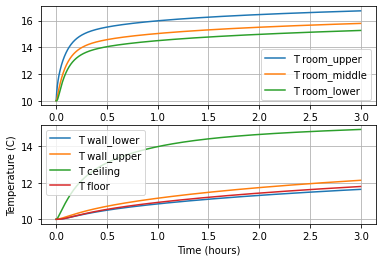

In [5]:
# MAKE PLOTS ##########################
fig, axs = plt.subplots(2)
t_array=np.arange(0,N_t_steps*t_step,t_step)/(60*60)
axs[0].plot(t_array,data_array_T_room_upper,label='T room_upper')
axs[0].plot(t_array,data_array_T_room_middle,label='T room_middle')
axs[0].plot(t_array,data_array_T_room_lower,label='T room_lower')
axs[0].legend()
axs[0].grid('True')
axs[1].plot(t_array,data_array_T_wall_lower,label='T wall_lower')
axs[1].plot(t_array,data_array_T_wall_upper,label='T wall_upper')
axs[1].plot(t_array,data_array_T_ceiling,label='T ceiling')
axs[1].plot(t_array,data_array_T_floor,label='T floor')
axs[1].legend()
axs[1].grid('True')
plt.xlabel('Time (hours)')
plt.ylabel('Temperature (C)')
print(data_array_T_room_lower[-1])

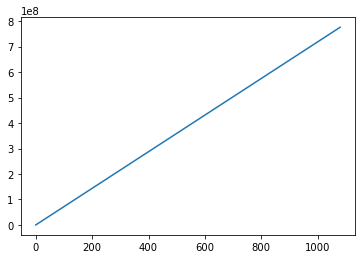

In [6]:
plt.plot( Qin_cumul)